# 2. Ligand-Receptor Inference

As a result of the growing interest in cell-cell communication (CCC) inference, a number of computational tools in single-cell transcriptomics have emerged. Although, there many different categories and approaches to infer CCC events, in this tutorial we will focus on those that infer interactions between ligands and receptors, commonly referred to as ligand-receptor (LR) inference methods (e.g. ([Efremova et al., 2020](https://www.nature.com/articles/s41596-020-0292-x), [Hou et al., 2020](https://www.nature.com/articles/s41467-020-18873-z), [Jin et al., 2021](https://www.nature.com/articles/s41467-021-21246-9), [Raredon et al., 2022](https://www.nature.com/articles/s41598-022-07959-x)). These tools typically rely on gene expression information as a proxy of protein abundance, and they work downstream of data pre-processing and acquisition of biologically-meaningful cell groups. These CCC tools infer intercellular interactions in a hypothesis-free manner, meaning that they infer all possible interactions between cell clusters, relying on prior knowledge of the potential interactions. Here, one group of cells is considered the source of the communication signal, sending a ligand, and the other is the receiver of the signal via its receptors. CCC events are thus represented as interactions between LR pairs, expressed by any combination of source and receiver cell groups.

The information about the interacting proteins is commonly extracted from prior knowledge resources. In the case of LR methods, the interactions can also be represented by heteromeric protein complexes ([Efremova et al., 2020](https://www.nature.com/articles/s41596-020-0292-x), [Jin et al., 2021](https://www.nature.com/articles/s41467-021-21246-9), [Noël et al., 2021](https://www.nature.com/articles/s41467-021-21244-x)). 

Here, we will use LIANA to obtain a consensus score for each LR interaction inferred by the different tools. Further, we will make use of LIANA's consensus resource, which combines a number of expert-curated LR resources.

## Environment Setup

In [1]:
import os
import numpy as np
import pandas as pd
import scipy

import scanpy as sc
import cell2cell as c2c

import liana as li
import plotnine as p9
import seaborn as sns
import matplotlib

from tqdm.auto import tqdm

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Directories

In [3]:
data_path = '../../data/'
output_folder = os.path.join(data_path, 'liana-outputs/')
c2c.io.directories.create_directory(output_folder)

../../data/liana-outputs/ already exists.


## Data Reminder

Here, we will re-load the processed data as processed in Tutorial 01.

In [4]:
adata = sc.read_h5ad(os.path.join(data_path, 'processed.h5ad'))

just as a quick reminder, let's visualize the cell types and samples in the data.

In [6]:
adata.obs.head()

,sample,sample_new,group,disease,hasnCoV,cluster,celltype,condition,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes
AAACCCACAGCTACAT_3,C100,HC3,HC,N,N,27.0,B,Control,1377,3124.0,287.0,9.186940,1377
AAACCCATCCACGGGT_3,C100,HC3,HC,N,N,23.0,Macrophages,Control,836,1430.0,13.0,0.909091,836
AAACCCATCCCATTCG_3,C100,HC3,HC,N,N,6.0,T,Control,1105,2342.0,148.0,6.319385,1105
AAACGAACAAACAGGC_3,C100,HC3,HC,N,N,10.0,Macrophages,Control,4530,31378.0,3132.0,9.981516,4530
AAACGAAGTCGCACAC_3,C100,HC3,HC,N,N,10.0,Macrophages,Control,3409,12767.0,659.0,5.161745,3409


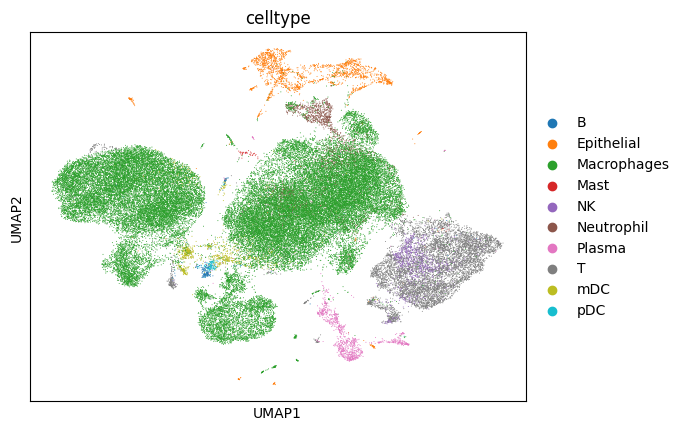

In [7]:
# plot pre-annotated cell types
sc.pl.umap(adata, color=['celltype']) # would do 'sample_new' only if we integrate

## Predicting CCC events with LIANA

<img src="https://github.com/saezlab/liana/blob/master/vignettes/ligrec_pipe.png?raw=true" width="900"/>

Now that we have the preprocessed data loaded, we will use liana to score the interactions inferred by the different tools.

`liana` is highly modularized and it implements a number of methods to score LR interactions, we can list those with the following command: 


In [8]:
li.method.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,cellphone_pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,CellChat,lr_probs,cellchat_pvals,"Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,Geometric Mean,lr_gmeans,gmean_pvals,CellPhoneDBv2's permutation approach applied t...


LIANA classifies interaction scores into two categories: those that infer the **Magnitude** and **Specificity** of interactions. The **Magnitude** of an interactions is a measure of the strength of the interaction's expression, and the **Specificity** of an interaction is a measure of how specific is an interaction to a given pair of clusters. Generally, these categories are complementary, and the magnitude of the interaction is a proxy of the specificity of the interaction. For example, a ligand-receptor interaction with a high magnitude score is likely to be specific, and vice versa. 

## Scoring Functions

We will now describe the mathematical formulation of the magnitude and specificity scores we will use in this tutorial:

### Shared Notations


`k` is the k-th ligand-receptor interaction 

`L` - expression of ligand L

`R` - expression of receptor R

`C` - cell cluster

`i` - cell group i

`j` - cell group j

`M` - the library-size normalized and log1p-transformed gene expression matrix

`X` - normalized gene expression vector

Note that `L` & `R` can also denote the interaction of any other CCC event category, such as those that between membrane-bound or extracellular matrix proteins.
Furthermore, in the case of complexes `L` & `R` denote the summarized* expression of the complex.

### CellPhoneDBv2
**Magnitude**: $$ LRmean_{k,i,j} = \frac{L_{C_{i}} + R_{C_{j}}}{2}$$

**Specificity**: CellPhoneDBv2 introduced a **permutation approach** also adapted by other methods, see permutation formulation below.


### Geometric Mean
**Magnitude**: $$ LRgeometric.mean_{k,i,j} = \sqrt{L_{C_{i}} \cdot R_{C_{j}}}$$

**Specificity**:
An adaptation of CellPhoneDBv2's permutation approach.

### CellChat (a resource-agnostic adaptation)

**Magnitude**:

$$LRprob_{k,i,j} = \frac{TriMean(L_{C_{i}}) \cdot
TriMean(R_{C_{j}})}{Kh + TriMean(L_{C_{i}}) \cdot
TriMean(R_{C_{j}})}$$

where Kh = 0.5 by default and `TriMean` represents Tuckey's Trimean function:

$$TriMean(X) = \frac{Q_{0.25}(X) + 2 \cdot Q_{0.5}(X) + Q_{0.75}(X)}{4}$$

Note that the original CellChat implementation also uses information of mediator proteins, which is specific to the CellChat resource.
Since we can use any resource with liana, by default liana's consensus resource, we will not use this information, and hence the implementation of CellChat's `LR_probability` in LIANA was simplified to be resource-agnostic.

**Specificity**:
An adaptation of CellPhoneDBv2's permutation approach.

##### The specificity scores of these three method is calculated as follows:

$$p\text{-value}_{k,i,j} = \frac{1}{P} \sum_{p=1}^{P} [fun_{permuted}(L^*_{C_{i}}, R^*_{C_{j}}) \geq fun_{observed}(L^*_{C_{i}}, R^*_{C_{j}})]$$

where `P` is the number of permutations, and `L*` and `R*` are ligand and receptor expression summarized according by each method, i.e. `arithmetic mean` for CellPhoneDB and Geometric Mean, and `TriMean` for CellChat.

### SingleCellSignalR

**Magnitude**:

$$LRscore_{k,i,j} = \frac{\sqrt{L_{C_{i}} R_{C_{j}}}}{\sqrt{L_{C_{i}} R_{C_{j}}} + \mu}$$


where `mu` is the mean of the expression matrix `M`

### NATMI

**Magnitude**: $$LRproduct_{k,i,j} = L_{C_{i}} R_{C_{j}}$$

**Specificity**: $$SpecificityWeight_{k,i,j} = \frac{L_{C_{i}}}{\sum^{n} L_{C_{i}}} \cdot \frac{R_{C_{j}}}{\sum^{n} R_{C_{j}}}$$

### Connectome

**Magnitude**: $$LRproduct_{k,i,j} = L_{C_{i}} R_{C_{j}}$$

**Specificity**:  $$ LRz.mean_{k,i,j} = \frac{z_{L_{C_{i}}} + z_{R_{C_{j}}}}{2} $$

where `z` is the z-score of the expression matrix `M`:

$$ X_{z} = (X - mean(X)) / std(X) $$

### log2FC

**Specificity**: $$ LRlog2FC_{k,i,j} = \frac{\text{Log2FC}_{C_i,L} + \text{Log2FC}_{C_j,R}}{2} $$


where log2FC for each gene is calculated as: $$ log2FC = \log_2\left(\text{mean}(X_i)\right) - \log_2\left(\text{mean}(X_{\text{not}_i})\right) $$



What the above equations show is that there are many commonalities between the different methods, yet there are also many variations in the way the magnitude and specificity scores are calculated. 

$$ I \left\{ L_{C_j}^{expr.prop} \geq 0.1 \text{ and } R_{C_j}^{expr.prop} \geq 0.1 \right\} $$

where liana considers interactions as occurring only if the ligand and receptor, and **all** of their subunits, are expressed by default in at least 0.1 of the cells (`>= expr_prop`) in cell clusters `i`, `j`.
Any interactions that don't pass these criteria are not returned by default, to return them the user can check the `return_all_lrs` parameter.

### Score Distributions

In [5]:
# pick a sample to infer the communication scores for
sample_name = 'C100'
sadata = adata[adata.obs['sample']==sample_name]
sadata

View of AnnData object with n_obs × n_vars = 2550 × 24798
    obs: 'sample', 'sample_new', 'group', 'disease', 'hasnCoV', 'cluster', 'celltype', 'condition', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'celltype_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

The parameters that we will use are the following:
- `groupby` corresponds to the cell group label stored in `adata.obs`.
- `use_raw` is boolean that indicates whether to use the `adata.raw` slot, here the log-normalized counts are assigned to `adata.X`, other options include passing the name of a layer via the `layer` parameter or using the counts stored in `adata.raw`.
- `expr_prop` is the expression proportion threshold  (in terms of cells per cell type expressing the protein)threshold of expression for any protein subunit involved in the interaction, according to which we keep or discard the interactions.
- `min_cells` is the minimum number of cells per cell type required for a cell type to be considered in the analysis
- `verbose` is a boolean that indicates whether to print the progress of the function

(Other parameters are described in the documentation of the function, as well as in more detail below)

In [6]:
%%time
li.method.rank_aggregate(sadata, 
                           groupby='celltype', 
                           resource_name = 'consensus',
                           expr_prop=0.1, # must be expressed in expr_prop fraction of cells
                           min_cells = 5,
                           n_perms = 1000, 
                           use_raw = False, # run on log- and library-normalized counts
                           verbose = True, 
                           inplace = True
                          )

Using `.X`!
5580 features of mat are empty, they will be removed.
The following cell identities were excluded: Plasma
Using resource `consensus`.
0.33 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 2548 samples and 19218 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.51it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:38<00:00, 25.67it/s]


CPU times: user 50.4 s, sys: 648 ms, total: 51.1 s
Wall time: 50.7 s


LIANA's results are by default save to the `liana_res` slot in `adata.uns`

In [7]:
liana_res = sadata.uns['liana_res'].copy()
liana_res.to_csv(os.path.join(output_folder, sample_name + '_aggregate_scores.csv'))
# only keep those that are not liana's ranks
liana_res.head()

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank
5665,NK,NK,B2M,KLRC1,3.738849,0.0,11.625175,1.746263,1.780719,0.093731,0.958522,0.278479,0.0,0.000145,1.314594e-10
5756,T,NK,B2M,KLRC1,3.751150,0.0,11.679413,1.770161,1.832493,0.094169,0.958614,0.277996,0.0,0.000143,4.431054e-10
5645,NK,NK,B2M,KLRD1,3.709523,0.0,11.315901,2.054310,1.865720,0.103861,0.957982,0.271253,0.0,0.000091,2.053588e-09
5731,T,NK,B2M,KLRD1,3.721824,0.0,11.368696,2.078208,1.917494,0.104346,0.958076,0.270777,0.0,0.000091,3.544038e-09
6624,NK,T,B2M,CD3D,3.706217,0.0,11.281032,1.257045,1.837345,0.069132,0.957920,0.267706,0.0,0.001595,6.921164e-09


Here, we can see all of the different scores for each method, as well as the consensus scores for `magnitude` and `specificity`.

As a reminder, each output score (column names in the above dataframe) can be mapped back to the scoring method and scoring type (i.e., magnitude vs specificity):

In [8]:
li.method.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,cellphone_pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,CellChat,lr_probs,cellchat_pvals,"Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,Geometric Mean,lr_gmeans,gmean_pvals,CellPhoneDBv2's permutation approach applied t...


To provide a better illustration of the different scores, we will now plot the distribution of scores for each of the methods.

In [18]:
# convert to long format by index, and each score and value in different columns
liana_res = liana_res.loc[:, liana_res.columns[~liana_res.columns.str.contains(pat = 'rank')]]
liana_res = liana_res.melt(id_vars=['source', 'target', 'ligand_complex', 'receptor_complex'], var_name='score', value_name='value')

liana_res['score'] = liana_res['score'].astype('category')

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


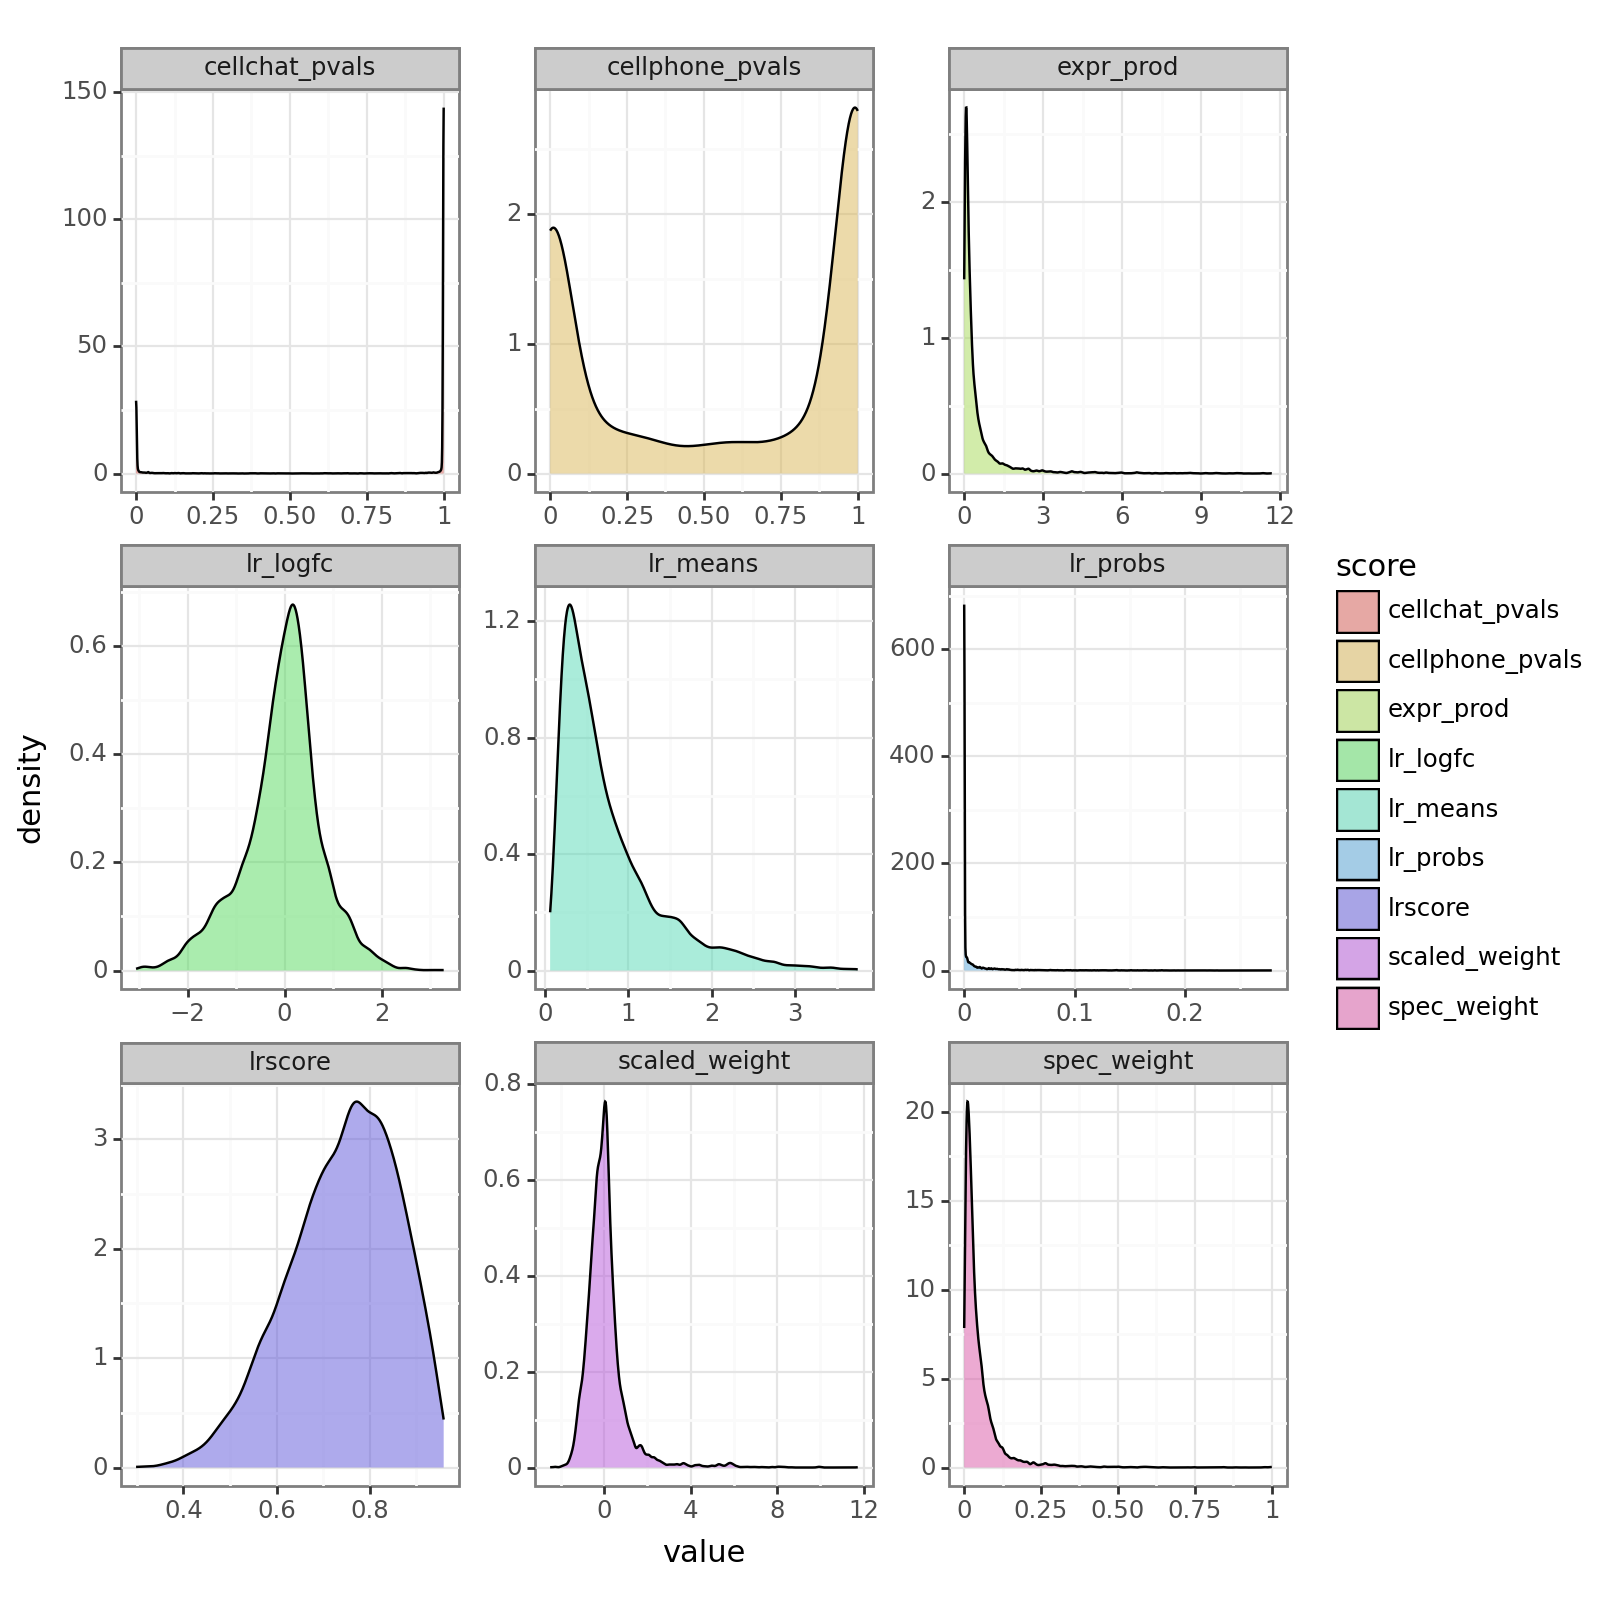

<Figure Size: (800 x 800)>

In [15]:
(p9.ggplot(liana_res, p9.aes(x='value', fill='score')) + 
 p9.geom_density(alpha=0.5) + 
 p9.facet_wrap('~score', scales='free') +
 p9.theme_bw() +
 p9.theme(figure_size=(8, 8))
 )

We can also observe the consistency between, for example, the magnitude scores between the various methods. Let's do so by taking the correlation between them:

In [9]:
magnitude_scores = ['lr_means', 'expr_prod', 'lrscore', 'lr_probs']
liana_corr = sadata.uns['liana_res'].copy()[magnitude_scores].corr(method = 'spearman')

Interaction space detected as a distance matrix


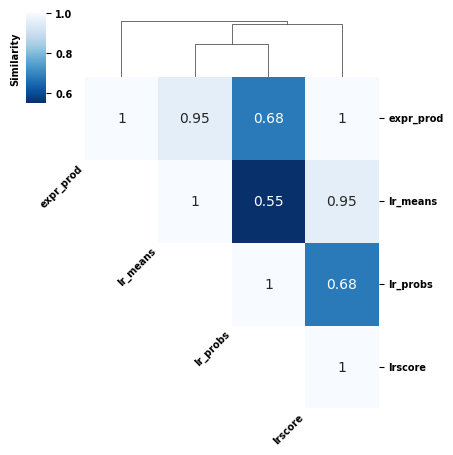

In [10]:
cm = c2c.plotting.clustermap_cci(liana_corr,
                                 method='ward',
                                 optimal_leaf=True,
                                 metadata=None,
                                 title='',
                                 cbar_title='Similarity', 
                                 cmap='Blues_r',
                                 vmax=1.,
#                                  vmin=0.,
                                 annot=True, 
                                 dendrogram_ratio=0.15,
                                figsize=(4,5))

font = matplotlib.font_manager.FontProperties(weight='bold', size=7)
for ax in [cm.ax_heatmap, cm.ax_cbar]:
    for tick in ax.get_xticklabels():
        tick.set_fontproperties(font)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties(font)

    text = ax.yaxis.label
    text.set_font_properties(font)

As can be seen, for this sample, CellChat has the most dissimilar communication scores.

This show the extent to which  each of the scoring functions differ from each other. Unsurprisingly, independent evaluations have shown that the choice of method and/or resource leads to limited consensus in inferred predictions when using different tools ([Dimitrov et al., 2022](https://www.nature.com/articles/s41467-022-30755-0), [Liu et al., 2022](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-022-02783-y), [Wang et al., 2022](https://academic.oup.com/bfg/article/21/5/339/6640320)). To this end, we have implemented a consensus score that is a rank aggregate of the scores obtained by the different methods, and for the sake of these tutorials we will use this consensus score to rank the interactions, specifically the one that aggregates the magnitude scores from different functions. Aggregate scores are also non-negative, which is beneficial for decomposition with Tensor-cell2cell.

To further explore the effects of scoring methods, see [Supplementary Tutorial S3](./S3_Score_Consistency.ipynb))

### LIANA's Rank Aggregate

LIANA calculates an aggregate rank for both `magnitude` and `specificity` as defined above. The `rank_aggregate` function of liana uses a re-implementation of the RobustRankAggregate method by [Kolde et al., 2012](https://pubmed.ncbi.nlm.nih.gov/22247279/), and generates a probability distribution for ligand-receptors that are ranked consistently better than expected under a null hypothesis. It thus provides a consensus of the rank of the ligand-receptor interactions across methods, that can also be treated as a p-value.

In more detail, a rank aggregate is calculated for the `magnitude` and `specificity` scores from the methods in LIANA as follows:

First, a normalized rank matrix[0,1] is generated separately for magnitude and specificity as: $$ r_{i,j} = \frac{rank_{i,j}}{\max(rank_i)} \quad (1 \leq i \leq m, 1 \leq j \leq n) $$

where `m` is the number of score rank vectors, `n` is the length of each score vector (number of interactions), **rank<sub>i,j</sub>** is the rank of the `j-th` element (interaction) in the `i-th` score rank vector, and **max(rank<sub>i</sub>)** is the maximum rank in the `i-th` rank vector.

For each normalized rank vector `r`, we then ask how probable is it to obtain **r<sup>null</sup><sub>(k)</sub> <= r<sub>(k)</sub>**, where **r<sup>null</sup><sub>(k)</sub>** is a rank vector generated under the null hypothesis. The RobustRankAggregate method expresses [Kolde et al., 2012](https://pubmed.ncbi.nlm.nih.gov/22247279/) the probability **r<sup>null</sup><sub>(k)</sub> <= r<sub>(k)</sub>** as **β<sub>k,n</sub>(r)**, through a beta distribution. 
This entails that we obtain probabilities for each score vector `r` as:

$$ p(r) = \underset{1, ..., n}{min} \beta_k,_n(r) * n $$

where we take the minimum probability `ρ` for each interaction across the score vectors, and we apply a Bonferroni correction to the p-values by multiplying them by `n` to account for multiple testing.

### Single-Sample Dotplot

Now that we are familiar with the what LIANA's aggregate scores are, let's generate a basic dotplot with the most highly-ranked ligand-receptor interactions for this sample.

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


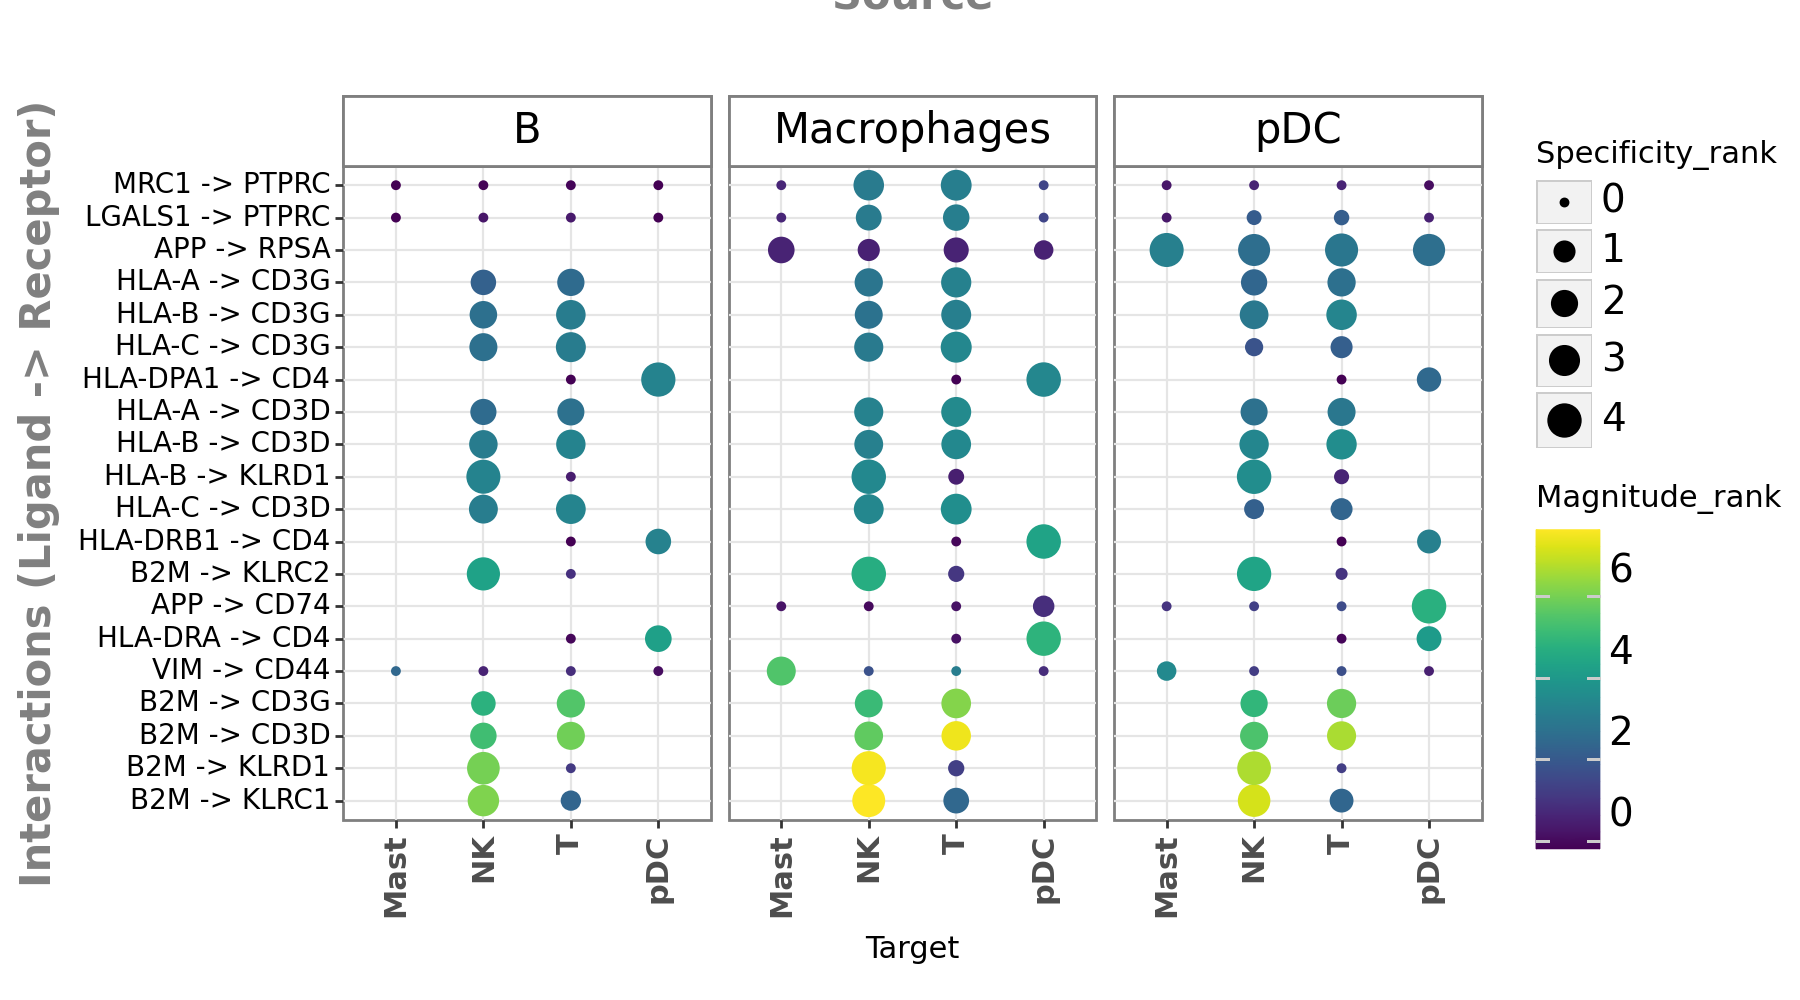

<Figure Size: (900 x 500)>

In [14]:
li.pl.dotplot(
    adata=sadata,
    colour="magnitude_rank",
    size="specificity_rank",
    inverse_colour=True,  # we inverse sign since we want small p-values to have large sizes
    inverse_size=True,
    # We choose only the cell types which we wish to plot
    source_labels=["B", "pDC", "Macrophages"],
    target_labels=["T", "Mast", "pDC", "NK"],
    # since the rank_aggregate can also be interpreted as a probability distribution
    # we can again filter them according to their specificity significance
    # yet here the interactions are filtered according to
    # how consistently highly-ranked is their specificity across the methods
    filterby="specificity_rank",
    filter_lambda=lambda x: x <= 0.05,
    # again, we can also further order according to magnitude
    orderby="magnitude_rank",
    orderby_ascending=True,  # prioritize those with lowest values
    top_n=20,  # and we want to keep only the top 20 interactions
    figure_size=(9, 5),
    size_range=(1, 6),
)

Great! We have now obtained ligand-receptor predictions for a single sample. What we see here is that interactions are predicted across cell types and are typically specific to pairs of cell types.

Note that missing dots here would represent interactions for which the ligand and receptor are expressed below the `expr_prop` threshold.

## Run LIANA by Sample

Now that we have familiarized ourselves with how ligand-receptor methods work and how the results look by sample, let's run LIANA's `rank_aggregate` on all of the samples in the dataset. These results will be used to generate a tensor of ligand-receptor interactions across contexts that will be decomposed into CCC patterns by `Tensor-Cell2cell`.

This is easily done with liana with the internal to the method instances function called `by_sample`. So, we will use the same parameters as before, but we will also add the `by_sample` parameter, which is a string that indicates the column in the `adata.obs` dataframe.

We relax the `expr_prop` parameter to have more consistent presence of LR interactions across contexts. See further discussions on the `how` parameter in Tutorial 03. 

In [15]:
%%time
li.mt.rank_aggregate.by_sample(adata, 
                               sample_key='sample_new', 
                               groupby='celltype', 
                               resource_name = 'consensus',
                               expr_prop=0.1, # must be expressed in expr_prop fraction of cells
                               min_cells = 5,
                               n_perms = 100, 
                               use_raw = False, # run on log- and library-normalized counts
                               verbose = True, 
                               inplace = True
                              )

Now running: S6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [03:47<00:00, 18.95s/it]

CPU times: user 3min 42s, sys: 6.81 s, total: 3min 49s
Wall time: 3min 47s


### Check the results

Here, we can see that the results look very similar as before with the exception that we have an additional column for the sample name, and the results are now by sample.

In [16]:
adata.uns['liana_res'].head()

,sample_new,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,specificity_rank,magnitude_rank
0,HC1,Macrophages,NK,B2M,CD3D,3.410504,0.0,8.059611,1.300556,1.397895,0.083273,0.961040,0.221495,0.0,0.003713,1.698996e-09
1,HC1,T,NK,B2M,CD3D,3.410586,0.0,8.059861,1.300856,1.272266,0.083276,0.961041,0.221213,0.0,0.003713,6.256593e-09
2,HC1,NK,NK,B2M,CD3D,3.264099,0.0,7.614378,0.790913,1.113901,0.078673,0.959963,0.216816,0.0,0.006245,2.653267e-08
3,HC1,T,NK,B2M,KLRD1,3.297900,0.0,6.865250,6.960920,1.244892,0.171293,0.957924,0.214586,0.0,0.000092,9.767878e-08
4,HC1,Macrophages,NK,B2M,KLRD1,3.297818,0.0,6.865037,6.960620,1.370520,0.171288,0.957924,0.214861,0.0,0.000092,1.086199e-07


We can also generate a dotplot for the most highly-ranked ligand-receptor interactions for each sample.
Let's pick the first two distinct interaction in the list, and see how they look like in the `dotplot_by_sample`.

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


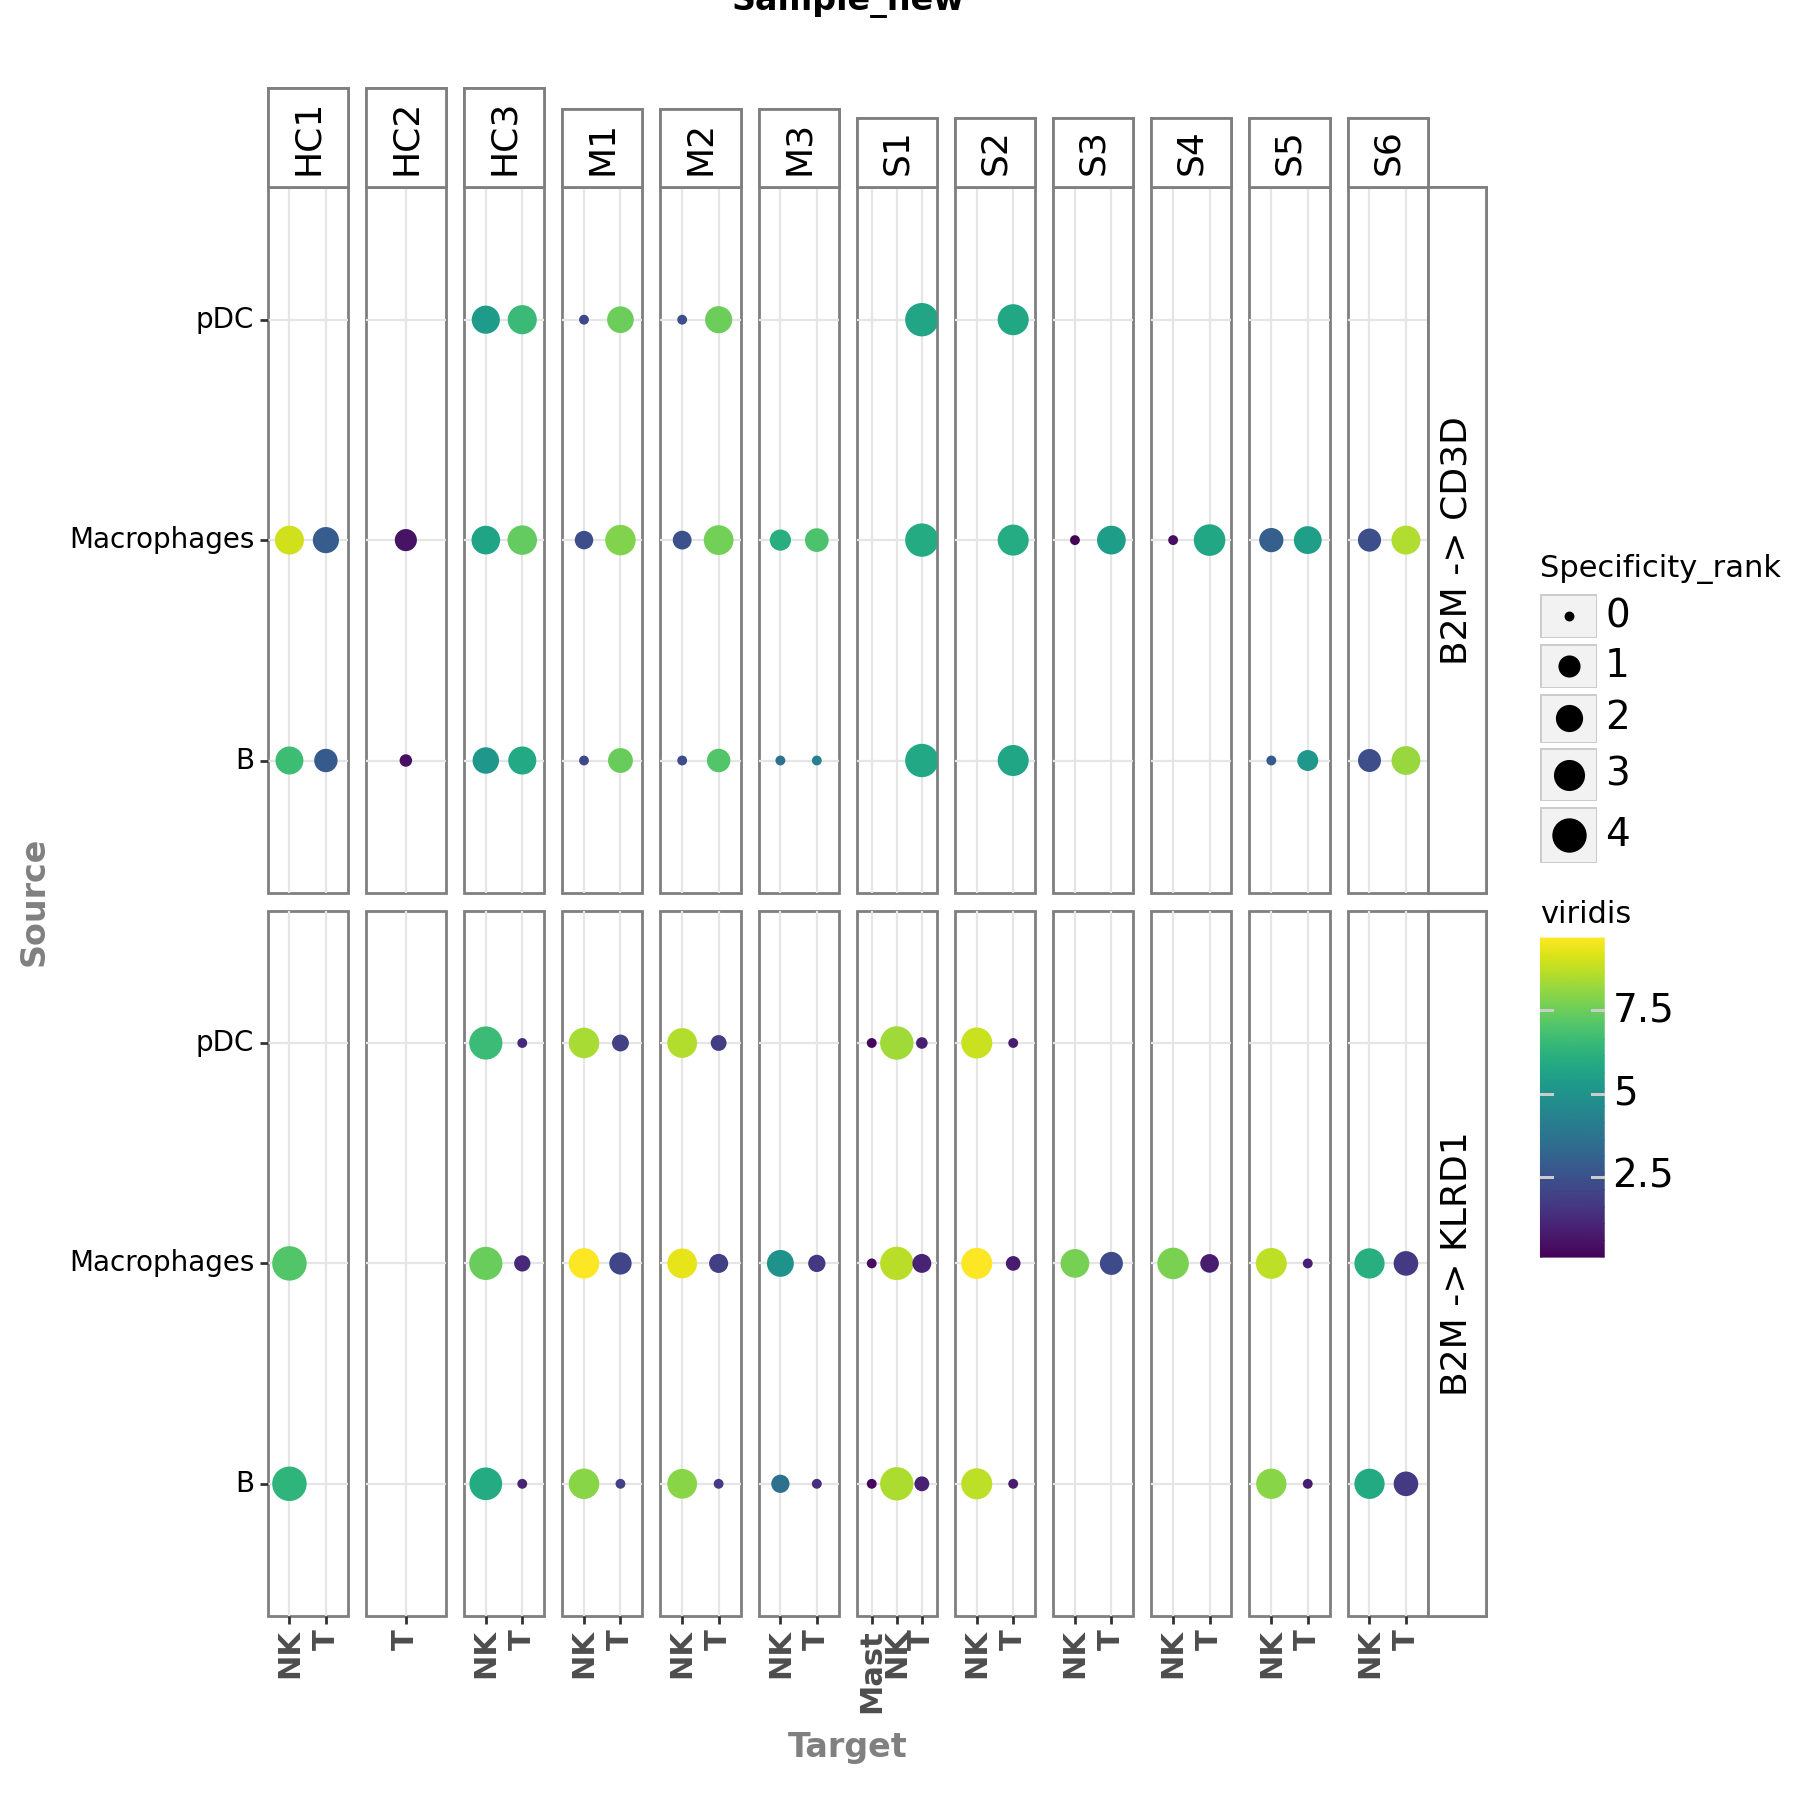

<Figure Size: (900 x 900)>

In [17]:
li.pl.dotplot_by_sample(adata=adata,
                        colour='magnitude_rank',
                        size='specificity_rank',
                        source_labels=["B", "pDC", "Macrophages"],
                        target_labels=["T", "Mast", "pDC", "NK"],
                        ligand_complex = 'B2M',
                        receptor_complex= ['CD3D', 'KLRD1'],
                        sample_key='sample_new',
                        inverse_colour=True,
                        inverse_size=True,
                        figure_size=(9, 9),
                        size_range=(1, 6),
                        )

Here, we can already see that the ligand-receptor interactions are not only specific to cell types, but also to samples or contexts (see **B2M -> KLRD1** in samples *M1*, *M2*, *M3*). However, we can also see that this plot, even with just two ligand-receptor interactions visualized, starts to get a bit overwhelming. To this end, to make the most use of the hypothesis-free nature of the ligand-receptor interactions, in the next chapter we will use `Tensor-Cell2cell` to decompose the ligand-receptor interactions into interpretable CCC patterns across contexts.

Save Results for Tensor-Cell2cell

In [18]:
adata.uns['liana_res'].to_csv(output_folder + '/LIANA_by_sample.csv', index=False)

Next Chapter: 03-Generate-Tensor.

## Supplementary Information about LIANA

### Independent Methods

Although, in these tutorials we will use the consensus score, one can also run the different methods independently via LIANA.

In [19]:
from liana.method import cellphonedb, cellchat, geometric_mean, singlecellsignalr, natmi, connectome, logfc

Each of these is an instance of Class Method in LIANA and comes with it's own metadata. For example, let's examine the metadata of the CellPhoneDBv2 method:

In [20]:
cellphonedb.describe()

CellPhoneDB uses `lr_means` and `cellphone_pvals` as measures of expression strength and interaction specificity, respectively


We can also check in what order one should interpret the results from each method:

In [21]:
{ cellphonedb.magnitude : cellphonedb.magnitude_ascending }

{'lr_means': False}

In [22]:
{ cellphonedb.specificity : cellphonedb.specificity_ascending }

{'cellphone_pvals': True}

Similarly, we can obtain the reference for the method:

In [23]:
cellphonedb.reference

'Efremova, M., Vento-Tormo, M., Teichmann, S.A. and Vento-Tormo, R., 2020. CellPhoneDB: inferring cell–cell communication from combined expression of multi-subunit ligand–receptor complexes. Nature protocols, 15(4), pp.1484-1506. '

### Key Parameters

We already covered some of the parameters in LIANA, that can be used to customize the results. Here, we will go in more detail over some of the most important ones.


- `resource` and `resource_name` enable the user to select the resource that they want to use for CCC inference. By default, liana will use the 'consensus' resource which combines a number of expert-curated ligand-receptor resources. However, one can also use the 'cellphonedb' resource, any of the resources that are available within liana by passing their `resource_name` (See below). Additionally, the user can pass their own resource via the `resource` parameter, which expects a pandas DataFrame.


In [24]:
li.resource.show_resources()

['baccin2019',
 'cellcall',
 'cellchatdb',
 'cellinker',
 'cellphonedb',
 'celltalkdb',
 'connectomedb2020',
 'consensus',
 'embrace',
 'guide2pharma',
 'hpmr',
 'icellnet',
 'italk',
 'kirouac2010',
 'lrdb',
 'mouseconsensus',
 'ramilowski2015']


- `expr_prop` which we also used before is the proportion of cells that need to express a ligand-receptor pair for it to be considered as a potential ligand-receptor pair. This is a parameter that can be used to filter out lowly-expressed ligand-receptor pairs. This is common practice in CCC inference at the cluster level, as we make the assumption that the event occurs for all cells within that clusters. By default, it is assigned to 0.1 - i.e. 10% of cells need to express the ligand-receptor and pair, including all of their subunits, in the corresponding clusters.

- `return_all_lrs` is related to the `expr_prop` parameter. If `return_all_lrs` is set to `True`, then all ligand-receptor pairs will be returned, regardless of whether they are expressed above the `expr_prop` threshold. When `return_all_lrs` is set to `True`, all interactions are returned and for all above `expr_prop` liana would calculate the score as usual, while the remainder get the worst possible score within the list of scores. Furthermore, a column with the `lrs_to_keep` flag is added to the `adata.uns['liana_res']` dataframe that indicates whether the interaction and any of its members passed the `expr_prop` threshold. This flag is for example used by the `li.multi.to_tensor_c2c` described in the next tutorial.
This is useful if one wants to use the `expr_prop` parameter to filter out lowly-expressed ligand-receptor pairs, but still wants to see the scores for all ligand-receptor pairs. By default, it is set to `False`, which means that only ligand-receptor pairs that are expressed above the `expr_prop` threshold will be returned. 

- `supp_columns` is a list of columns that can be added to the `adata.uns['liana_res']` dataframe. These are typically other stats that are calculated for each ligand and receptor, such as the 1vsRest differential expression p-value, or any other stat from another method.

In addition to those parameters liana provides a number of other utility parameters as well as some method-specific ones, please refer to the documentation for more information.

In [25]:
?cellphonedb

### Alternative Resources

In addition to the resources already provided with LIANA, one can also use their own resource. This can be done by passing a pandas DataFrame to the `resource` parameter. The DataFrame should have the following columns: `ligand`, `receptor`, where subunits are separated by `_`.

Let's load the immune-focused resource by [Noël et al., 2021](https://www.nature.com/articles/s41467-021-21244-x) for obtained from https://github.com/LewisLabUCSD/Ligand-Receptor-Pairs:

In [37]:
resource = pd.read_csv("../../data/Human-2020-Noël-LR-pairs.csv")
resource.head(6)

,Ligand 1,Ligand 2,Receptor 1,Receptor 2,Receptor 3,Alias,Family,Subfamily,Classifications,Source for interaction,PubMed ID,Comments
0,HLA-A,NaN,LILRB1,NaN,NaN,NaN,Antigen binding,NaN,Antigen binding,NaN,9285411; 9382880,NaN
1,HLA-B,NaN,LILRB1,NaN,NaN,NaN,Antigen binding,NaN,Antigen binding,NaN,9285411; 9382880,NaN
2,HLA-C,NaN,LILRB1,NaN,NaN,NaN,Antigen binding,NaN,Antigen binding,NaN,9285411; 9382880,NaN
3,HLA-F,NaN,LILRB1,NaN,NaN,NaN,Antigen binding,NaN,Antigen binding,NaN,9285411; 9382880,NaN
4,HLA-G,NaN,LILRB1,NaN,NaN,NaN,Antigen binding,NaN,Antigen binding,NaN,9285411; 9382880,NaN
5,IGHG1,IGLC1,FCGR3B,NaN,NaN,NaN,Antigen binding,NaN,Antigen binding,NaN,10917521,NaN


Now we need to just change it to be the same format as any other resource in liana, for example:

In [35]:
li.resource.select_resource('consensus').head()

,ligand,receptor
0,LGALS9,PTPRC
1,LGALS9,MET
2,LGALS9,CD44
3,LGALS9,LRP1
4,LGALS9,CD47


In [36]:
# Unite ligand1 and ligand2 into complexes acc to liana input, and do the same for receptor1 and receptor2
resource['ligand'] = resource['Ligand 1'] + ('_' + resource['Ligand 2']).fillna('')
resource['receptor'] = resource['Receptor 1'] + ('_' + resource['Receptor 2']).fillna('')
resource = resource.loc[:, ['ligand', 'receptor']]
resource.head(6)

,ligand,receptor
0,HLA-A,LILRB1
1,HLA-B,LILRB1
2,HLA-C,LILRB1
3,HLA-F,LILRB1
4,HLA-G,LILRB1
5,IGHG1_IGLC1,FCGR3B


In [29]:
# run with any method, in this case singlecellsignalr
li.mt.singlecellsignalr(sadata, resource=resource, groupby='celltype', use_raw=False, verbose=True)

Using `.X`!
5580 features of mat are empty, they will be removed.
The following cell identities were excluded: Plasma
0.25 of entities in the resource are missing from the data.


Using provided `resource`.
Generating ligand-receptor stats for 2548 samples and 19218 features


In [30]:
sadata.uns['liana_res']

,ligand,ligand_complex,ligand_means,ligand_props,mat_mean,receptor,receptor_complex,receptor_means,receptor_props,source,target,lrscore
577,MIF,MIF,0.950994,0.666667,0.147544,CD74,CD74,4.767055,1.000000,Mast,mDC,0.935195
724,MIF,MIF,0.950994,0.666667,0.147544,CD74,CD74,4.359042,1.000000,Mast,pDC,0.932430
228,MIF,MIF,0.950994,0.666667,0.147544,CD74,CD74,4.029520,0.993441,Mast,Macrophages,0.929911
37,MIF,MIF,0.950994,0.666667,0.147544,CD74,CD74,3.754743,0.888889,Mast,B,0.927575
605,MIF,MIF,0.664859,0.354839,0.147544,CD74,CD74,4.767055,1.000000,NK,mDC,0.923466
...,...,...,...,...,...,...,...,...,...,...,...,...
559,JAG1,JAG1,0.062933,0.111504,0.147544,NOTCH1,NOTCH1,0.167743,0.194175,Macrophages,mDC,0.410506
169,MIF,MIF,0.159508,0.111111,0.147544,CXCR2,CXCR2,0.062348,0.118063,B,Macrophages,0.403305
298,CXCL8,CXCL8,0.155774,0.166667,0.147544,CXCR2,CXCR2,0.062348,0.118063,pDC,Macrophages,0.400458
94,IL1A,IL1A,0.084155,0.147830,0.147544,IL1R1,IL1R1_IL1RAP,0.086664,0.153846,Macrophages,Epithelial,0.366612



Provided an appropriate resource, one could use liana with any ID category and any species, as long as the IDs of the resource match the `.var_names` in the `adata` object.
